## Document Classification.

### Problem Statement
We process documents related to mortgages, aka everything that happens to originate a mortgage that you don't see as a borrower. Often times the only access to a document we have is a scan of a fax of a print out of the document. Our system is able to read and comprehend that document, turning a PDF into structured business content that our customers can act on.

This dataset represents the output of the OCR stage of our data pipeline. Since these documents are sensitive financial documents we have not provided you with the raw text that was extracted. Instead we have had to obscure the data. Each word in the source is mapped to one unique value in the output. If the word appears in multiple documents then that value will appear multiple times. The word order for the dataset comes directly from our OCR layer, so it should be roughly in order.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("shuffled-full-set-hashed.csv", header = None)
df.columns = ['Category', 'Content']
display(df.head())
print("Shape of data is : {}".format(df.shape))

,Category,Content
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


Shape of data is : (62204, 2)


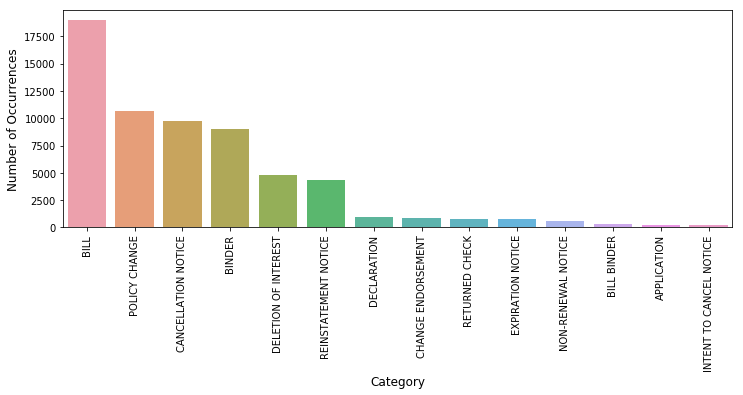

BILL                       18968
POLICY CHANGE              10627
CANCELLATION NOTICE         9731
BINDER                      8973
DELETION OF INTEREST        4826
REINSTATEMENT NOTICE        4368
DECLARATION                  968
CHANGE ENDORSEMENT           889
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
APPLICATION                  229
INTENT TO CANCEL NOTICE      229
Name: Category, dtype: int64


In [3]:
cnt_categories = df['Category'].value_counts()

plt.figure(figsize=(12,4))
g = sns.barplot(cnt_categories.index, cnt_categories.values, alpha=0.9)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)

plt.show()
print(cnt_categories)

In NLP, we pre-process data by removing stop words, changing the text to lower case, stemming, lemmatization. In our dataset, we cannot do these steps as the words are encoded. Hence, we will calculate Tf-IDF for all the words and use that as the feature for our classification.  The max-df value will act as a regularizing factor for our dataset. Setting a max-df and min-df value will allow our model to generalize. We will do cross-validation to evaluate the models.

In [4]:
# term frquency and document frequency vectorizer. Max_df and Min_df will filter out 
# terms that are very common(present in more than 44% of documents) or very rare(present in less than 1% documents)
# we will consider both 1 gram and 2 grams.
tfidf = TfidfVectorizer(sublinear_tf=True, max_df = 0.44, min_df = 0.01, norm='l2', ngram_range=(1, 2))

features = tfidf.fit_transform(df['Content'].values.astype('U')).toarray()
labels = df['Category']
all_categories = np.unique(labels)
features.shape

(62204, 3652)

We will analyze what most correlated unigrams and bigrams for each of the categories are. Although the words are encoded, we can check which words are more correlated to each of the classes, if we can decode those words back to original English words we can validate it.

In [9]:
N = 2
categories = []
most_corelated_unigrams = []
most_corelated_bigrams = []
for category_id in all_categories:
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    categories.append(category_id)
    most_corelated_unigrams.append(unigrams[-N:])
    most_corelated_bigrams.append(bigrams[-N:])

pd.DataFrame({'Category' : categories, 'Most corelated unigrams' : most_corelated_unigrams, 
              'Most corelated bigrams' : most_corelated_bigrams})

,Category,Most corelated unigrams,Most corelated bigrams
0,APPLICATION,"[823d2be57c98, 4298762de22f]","[8b0131ee1005 8b0131ee1005, 1fe62f2b2bff 9de56..."
1,BILL,"[d19b1c129f40, 641356219cbc]","[f95d0bea231b 21e314d3afcc, b9699ce57810 64135..."
2,BILL BINDER,"[93e786b92f57, 28b12e45914e]","[7d9e333a86da 360e8b28421c, fbe267908bc5 2f254..."
3,BINDER,"[388cbcf48919, d8535c18626a]","[6b343f522f78 d8535c18626a, d8535c18626a d3882..."
4,CANCELLATION NOTICE,"[79f872a2e298, 98d0d51b397c]","[b9699ce57810 98d0d51b397c, 98d0d51b397c eeb86..."
5,CHANGE ENDORSEMENT,"[1a46ce1e6826, 29b62a6f238b]","[458fb753e194 4e7b1501a15b, e616d3a38f90 29b62..."
6,DECLARATION,"[36d909566e5c, f36858486ddc]","[7d9e333a86da 360e8b28421c, 586242498a88 b7853..."
7,DELETION OF INTEREST,"[6b223a390d86, d774c0d219f8]","[ba02159e05b1 892d541c89eb, 6b223a390d86 6ce6c..."
8,EXPIRATION NOTICE,"[0e60c8ecc79d, 3bfb91f64987]","[094453b4e4ae 586242498a88, b9699ce57810 5d764..."
9,INTENT TO CANCEL NOTICE,"[74c7b4b972ff, 66b4e66655f9]","[d493c688fb66 07b93136ac77, eb562127f33e c0ed5..."


In [10]:
# We will try a few models
models = [
    LinearSVC(),
    LogisticRegression(random_state=0),
    MultinomialNB()
]

# 5 fold cross validation
CV = 5

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warn

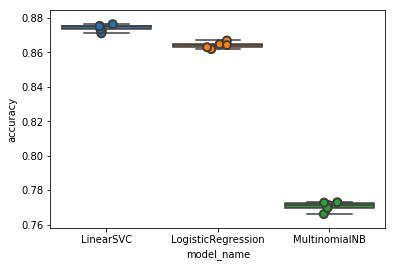

In [11]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [10]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [11]:
print(accuracy_score(y_test, y_pred))

0.8716341130134233


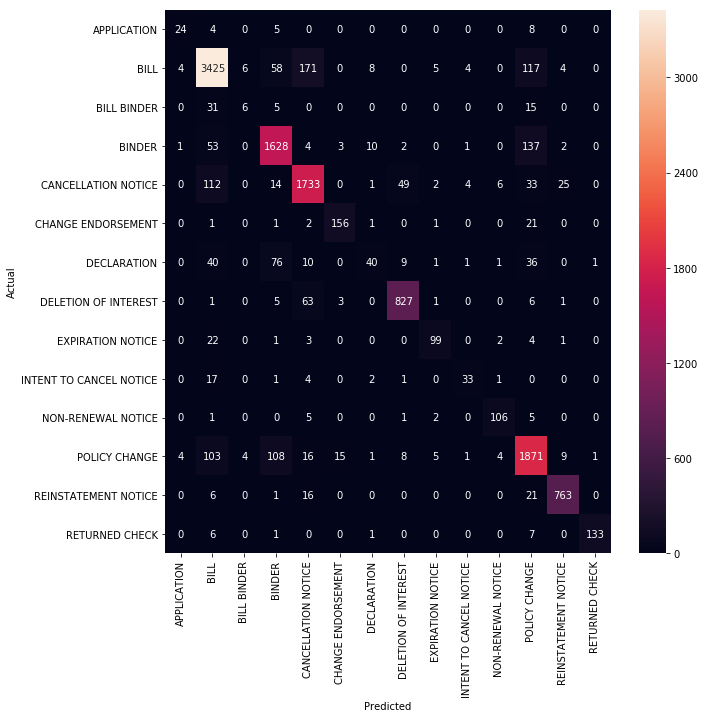

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
category_ids = df.groupby(['Category']).count().index
sns.heatmap(conf_mat, annot=True, fmt='d',
           xticklabels=category_ids, yticklabels=category_ids)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [80]:
# train a small model first and test.
#(features_train, labels_train) = (df.loc[1:50, 'Content'].values.astype('U'), df.loc[1:50, 'Category'])
(features_train, labels_train) = (df.loc[:, 'Content'].values.astype('U'), df.loc[:, 'Category'])

### TfidfVectorizer
tfidfv = TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.44, norm='l2')

## Selector.
selector = SelectKBest(chi2, k=1000)

## Linear SVC model.
linear_svc = LinearSVC()

calibrated_svc = CalibratedClassifierCV(linear_svc, method='sigmoid')

linearsvc = Pipeline([('vect', tfidfv),
                      ('selector', selector),
                      ('clf', calibrated_svc),
                      ])

linearsvc.fit(features_train, labels_train)
from sklearn.externals import joblib
joblib.dump(linearsvc, 'Flask_Application/model.pkl')

c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


['Flask_Application/model.pkl']

In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(df['Content'], df['Category'], random_state = 42, test_size=0.34)

### TfidfVectorizer
cv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')
features_train_cv = cv.fit_transform(features_train.values.astype('U'))

print("Feature Count\nCountVectorizer() #", len(cv.get_feature_names()))

selector = SelectKBest(chi2, k=1000)
selector.fit(features_train_cv, labels_train)

clf = LinearSVC()
clf.fit(selector.transform(features_train_cv), labels_train)


features_test_cv = cv.transform(features_test.values.astype('U'))
features_test_cv = selector.transform(features_test_cv)
pred = clf.predict(features_test_cv)
pred

Feature Count
CountVectorizer() # 3651


array(['BILL', 'BINDER', 'BILL', ..., 'CHANGE ENDORSEMENT',
       'CANCELLATION NOTICE', 'BILL'], dtype=object)

In [76]:
(features_train, labels_train) = (df.loc[1:40, 'Content'].values.astype('U'), df.loc[1:40, 'Category'])

### TfidfVectorizer
tfidfv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')

## Selector
selector = SelectKBest(chi2, k=1000)

linearsvc = Pipeline([('vect', tfidfv),
                ('selector', selector),
                ('clf', clf),
               ])
linearsvc.fit(features_train, labels_train)

from sklearn.externals import joblib
joblib.dump(linearsvc, 'Flask_Application/model_small.pkl')

['Flask_Application/model_small.pkl']

In [15]:
from sklearn.externals import joblib
joblib.dump(linearsvc, 'model_2.pkl', protocol=2)

['model_2.pkl']

In [16]:
classifier = open('model.pkl', 'rb')
model = joblib.load(classifier)

In [59]:
print(linearsvc.predict([df.iloc[1]['Content']]))
linearsvc.predict_proba([df.iloc[1]['Content']]).max()

['RETURNED CHECK']


0.7404794211208244

In [85]:
print(df.iloc[122]['Category'])
df.iloc[122]['Content']

BILL


'a86e61940a88 87b8193a0183 11e7ba3aad70 5768721c4059 d38820625542 6ca2dd348663 5e3551cde154 20a84e403407 b1980f7134ca a86e61940a88 3994376f7e92 7d9e333a86da 31eba8335f91 79aa7fd11cec b136f6349cf3 036087ac04f9 1dfee5aa1e4c e872b963c663 7146e19b9776 9b16d62c7990 a0e2fc3c1c98 f3ac381a9884 43af6db29054 1b6d0614f2c7 10e45001c2f2 586242498a88 a0e2fc3c1c98 ba8f19d976a8 3fc879c6be39 ce1f034abb5d a0c020166d79 6dcc75eaf823 6101ed18e42f 8d21095e8690 d19b1c129f40 48d657cd9861 4e5019f629a9 6bff0c8c1185 ce00eff819b7 ce1f034abb5d 25c57acdf805 ff478dde1f33 81757efac276 21e314d3afcc a1d5a5e41756 78192456b1f6 8f75273e5510 ba7229c9285d 4019c142c6b0 e5e97c8ea817 cd0bd661a41e 26f768da5068 6af770640118 26f768da5068 6af770640118 26f768da5068 6af770640118 dd3e0f7ead71 867946c6808d 2979f8b5c8c4 73ef9fd67984 73ef9fd67984 61dbb745c724 26f768da5068 7d0b2f99f8dc 83ea375ad9e5 0c4ce226d9fe 73ef9fd67984 de4f651eb63b fff0cfcb20d5 cbfb3eb99bea 43565b1afa44 2bcce4e05d9d 5948001254b3 2b2acdf4a3ed eb562127f33e 8f75273e551

In [30]:
df.iloc[0]

Category                                 DELETION OF INTEREST
Content     e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
Name: 0, dtype: object

In [24]:
from sklearn.externals import joblib
classifier = open('model_light.pkl', 'rb')
model = joblib.load(classifier)